# 🚲 Bergen Bike Availability Prediction System

## AI for Social Good: Sustainable Urban Mobility

**Team Members:** Ang Kar Kin, Nicolas Lasch, Chan Kok Siang

**Course:** 61.501 Production Ready ML (Y2025)

---

### Executive Summary

This project predicts bike availability at bike-sharing stations in Bergen, Norway, enabling:
- **Operators** to proactively manage bike distribution
- **Users** to find the best station based on location and predicted availability

We use interpretable ML models (Random Forest & XGBoost) to forecast hourly trip counts per station.

---

## 1. Environment Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All libraries imported successfully!
NumPy version: 2.1.3
Pandas version: 2.2.3


In [2]:
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

---

## 2. Data Loading & Preprocessing Functions

In [3]:
def load_dataset(filepath):
    return pd.read_csv(filepath)


def parse_timestamps(df):
    df = df.copy()
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    return df


def extract_temporal_features(df):
    df = df.copy()
    df['hour'] = df['start_time'].dt.hour
    df['day'] = df['start_time'].dt.day
    df['month'] = df['start_time'].dt.month
    df['dayofweek'] = df['start_time'].dt.dayofweek
    df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)
    return df


def clean_missing_values(df):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    return df


def remove_outliers(df, column, multiplier=3.0):
    df = df.copy()
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - multiplier * iqr
    upper = q3 + multiplier * iqr
    mask = (df[column] >= lower) & (df[column] <= upper)
    return df[mask]


def preprocess_pipeline(filepath):
    df = load_dataset(filepath)
    df = parse_timestamps(df)
    df = extract_temporal_features(df)
    df = clean_missing_values(df)
    df = remove_outliers(df, 'duration')
    return df

---

## 3. Feature Engineering Functions

In [4]:
def aggregate_station_hourly(df):
    hourly = df.groupby([
        'start_station_id',
        'start_station_name',
        df['start_time'].dt.date.rename('date'),
        'hour'
    ]).agg({
        'duration': 'count',
        'temperature': 'mean',
        'max_temperature': 'mean',
        'min_temperature': 'mean',
        'wind_speed': 'mean',
        'precipitation': 'mean',
        'humidity': 'mean',
        'sunshine': 'mean',
        'season': 'first',
        'is_holiday': 'first',
        'is_weekend': 'first',
        'start_station_latitude': 'first',
        'start_station_longitude': 'first',
        'is_rush_hour': 'first',
        'dayofweek': 'first',
        'month': 'first'
    }).reset_index()
    
    hourly = hourly.rename(columns={'duration': 'trip_count'})
    return hourly


def create_lag_features(df, lags=[1, 2, 3, 24]):
    df = df.copy()
    df = df.sort_values(['start_station_id', 'date', 'hour'])
    
    for lag in lags:
        df[f'trip_count_lag_{lag}'] = df.groupby('start_station_id')['trip_count'].shift(lag)
    
    return df


def create_rolling_features(df, windows=[3, 6, 24]):
    df = df.copy()
    df = df.sort_values(['start_station_id', 'date', 'hour'])
    
    for window in windows:
        df[f'trip_count_rolling_{window}h'] = df.groupby('start_station_id')['trip_count'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
    
    return df


def create_weather_interactions(df):
    df = df.copy()
    df['temp_humidity'] = df['temperature'] * df['humidity']
    df['temp_wind'] = df['temperature'] * df['wind_speed']
    df['rain_wind'] = df['precipitation'] * df['wind_speed']
    df['is_rainy'] = (df['precipitation'] > 0).astype(int)
    df['is_hot'] = (df['temperature'] > 20).astype(int)
    df['is_cold'] = (df['temperature'] < 5).astype(int)
    return df


def encode_cyclic_features(df):
    df = df.copy()
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df


def calculate_station_popularity(df):
    df = df.copy()
    station_stats = df.groupby('start_station_id')['trip_count'].agg(['mean', 'std']).reset_index()
    station_stats.columns = ['start_station_id', 'station_avg_trips', 'station_std_trips']
    df = df.merge(station_stats, on='start_station_id', how='left')
    return df


def feature_engineering_pipeline(df):
    df = aggregate_station_hourly(df)
    df = create_lag_features(df)
    df = create_rolling_features(df)
    df = create_weather_interactions(df)
    df = encode_cyclic_features(df)
    df = calculate_station_popularity(df)
    df = df.dropna()
    return df


def prepare_train_test_split(df, test_ratio=0.2):
    df = df.sort_values(['date', 'hour'])
    split_idx = int(len(df) * (1 - test_ratio))
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
    return train_df, test_df


def get_feature_columns():
    return [
        'temperature', 'max_temperature', 'min_temperature',
        'wind_speed', 'precipitation', 'humidity', 'sunshine',
        'season', 'is_holiday', 'is_weekend', 'is_rush_hour',
        'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
        'month_sin', 'month_cos',
        'trip_count_lag_1', 'trip_count_lag_2', 'trip_count_lag_3', 'trip_count_lag_24',
        'trip_count_rolling_3h', 'trip_count_rolling_6h', 'trip_count_rolling_24h',
        'temp_humidity', 'temp_wind', 'rain_wind',
        'is_rainy', 'is_hot', 'is_cold',
        'station_avg_trips', 'station_std_trips',
        'start_station_latitude', 'start_station_longitude'
    ]

---

## 4. Model Training & Evaluation Functions

In [5]:
def train_random_forest(X_train, y_train, params=None):
    if params is None:
        params = {
            'n_estimators': 100,
            'max_depth': 15,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'random_state': 42,
            'n_jobs': -1
        }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    return model


def train_xgboost(X_train, y_train, params=None):
    if params is None:
        params = {
            'n_estimators': 100,
            'max_depth': 8,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'n_jobs': -1
        }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model


def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}


def get_feature_importance(model, feature_names):
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    return importance_df


def hyperparameter_tuning_rf(X_train, y_train, X_val, y_val):
    param_grid = [
        {'n_estimators': 50, 'max_depth': 10},
        {'n_estimators': 100, 'max_depth': 15},
        {'n_estimators': 150, 'max_depth': 20},
        {'n_estimators': 200, 'max_depth': 25}
    ]
    
    best_score = float('inf')
    best_model = None
    best_params = None
    
    for params in param_grid:
        model = train_random_forest(X_train, y_train, {**params, 'random_state': 42, 'n_jobs': -1})
        metrics = evaluate_model(model, X_val, y_val)
        if metrics['RMSE'] < best_score:
            best_score = metrics['RMSE']
            best_model = model
            best_params = params
    
    return best_model, best_params


def hyperparameter_tuning_xgb(X_train, y_train, X_val, y_val):
    param_grid = [
        {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.1},
        {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1},
        {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05},
        {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.05}
    ]
    
    best_score = float('inf')
    best_model = None
    best_params = None
    
    for params in param_grid:
        model = train_xgboost(X_train, y_train, {**params, 'random_state': 42, 'n_jobs': -1})
        metrics = evaluate_model(model, X_val, y_val)
        if metrics['RMSE'] < best_score:
            best_score = metrics['RMSE']
            best_model = model
            best_params = params
    
    return best_model, best_params


def compare_models(models, X_test, y_test):
    results = []
    for name, model in models.items():
        metrics = evaluate_model(model, X_test, y_test)
        metrics['model'] = name
        results.append(metrics)
    return pd.DataFrame(results).set_index('model')

---

## 5. Station Recommendation Functions

In [6]:
def calculate_distance(lat1, lon1, lat2, lon2):
    from math import radians, cos, sin, asin, sqrt
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r


def get_nearby_stations(user_lat, user_lon, stations_df, radius_km=2.0):
    stations = stations_df.copy()
    stations['distance_km'] = stations.apply(
        lambda row: calculate_distance(user_lat, user_lon, row['start_station_latitude'], row['start_station_longitude']),
        axis=1
    )
    nearby = stations[stations['distance_km'] <= radius_km].sort_values('distance_km')
    return nearby


def calculate_recommendation_score(distance, predicted_trips, max_distance=2.0):
    distance_score = 1 - (distance / max_distance)
    availability_score = min(predicted_trips / 10, 1.0)
    combined_score = 0.4 * distance_score + 0.6 * availability_score
    return combined_score


def recommend_best_station(user_lat, user_lon, target_hour, stations_info, features_df, model, feature_cols, top_k=3):
    unique_stations = stations_info[['start_station_id', 'start_station_name', 
                                      'start_station_latitude', 'start_station_longitude']].drop_duplicates()
    nearby = get_nearby_stations(user_lat, user_lon, unique_stations, radius_km=2.0)
    
    if nearby.empty:
        return pd.DataFrame()
    
    recommendations = []
    for _, station in nearby.iterrows():
        station_features = features_df[
            (features_df['start_station_id'] == station['start_station_id']) &
            (features_df['hour'] == target_hour)
        ]
        
        if station_features.empty:
            continue
        
        latest_features = station_features.iloc[-1:][feature_cols]
        predicted_trips = model.predict(latest_features)[0]
        score = calculate_recommendation_score(station['distance_km'], predicted_trips)
        
        recommendations.append({
            'station_id': station['start_station_id'],
            'station_name': station['start_station_name'],
            'latitude': station['start_station_latitude'],
            'longitude': station['start_station_longitude'],
            'distance_km': station['distance_km'],
            'predicted_trips': predicted_trips,
            'recommendation_score': score
        })
    
    rec_df = pd.DataFrame(recommendations)
    rec_df = rec_df.sort_values('recommendation_score', ascending=False).head(top_k)
    return rec_df


def format_recommendation_output(recommendations):
    if recommendations.empty:
        return "No stations found nearby. Try increasing the search radius."
    
    output_lines = ["Top Station Recommendations:\n"]
    for idx, row in recommendations.iterrows():
        output_lines.append(f"Station: {row['station_name']}")
        output_lines.append(f"  Distance: {row['distance_km']:.2f} km")
        output_lines.append(f"  Predicted Activity: {row['predicted_trips']:.1f} trips/hour")
        output_lines.append(f"  Score: {row['recommendation_score']:.3f}")
        output_lines.append("")
    return "\n".join(output_lines)

---

## 6. Visualization Functions

In [7]:
def set_plot_style():
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['font.size'] = 12


def plot_feature_importance(importance_df, top_n=15):
    set_plot_style()
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = importance_df.head(top_n)
    bars = ax.barh(range(len(top_features)), top_features['importance'].values)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'].values)
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Top {top_n} Most Important Features')
    ax.invert_yaxis()
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', ha='left', va='center')
    plt.tight_layout()
    return fig


def plot_actual_vs_predicted(y_true, y_pred):
    set_plot_style()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(y_true, y_pred, alpha=0.5, s=10)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Trip Count')
    ax.set_ylabel('Predicted Trip Count')
    ax.set_title('Actual vs Predicted Trip Counts')
    ax.legend()
    plt.tight_layout()
    return fig


def plot_residuals(y_true, y_pred):
    set_plot_style()
    residuals = y_true - y_pred
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].scatter(y_pred, residuals, alpha=0.5, s=10)
    axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title('Residuals vs Predicted Values')
    axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Residual Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Residuals')
    plt.tight_layout()
    return fig


def plot_hourly_patterns(df):
    set_plot_style()
    hourly_avg = df.groupby('hour')['trip_count'].mean()
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8)
    ax.fill_between(hourly_avg.index, hourly_avg.values, alpha=0.3)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Trip Count')
    ax.set_title('Average Bike Trips by Hour of Day')
    ax.set_xticks(range(24))
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig


def plot_weather_correlation(df):
    set_plot_style()
    weather_cols = ['temperature', 'humidity', 'wind_speed', 'precipitation', 'sunshine', 'trip_count']
    corr_matrix = df[weather_cols].corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
                linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax, fmt='.2f')
    ax.set_title('Correlation Matrix: Weather vs Trip Count')
    plt.tight_layout()
    return fig


def plot_model_comparison(comparison_df):
    set_plot_style()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    metrics = ['RMSE', 'MAE', 'R2']
    colors = sns.color_palette("husl", len(comparison_df))
    for idx, metric in enumerate(metrics):
        bars = axes[idx].bar(comparison_df.index, comparison_df[metric], color=colors)
        axes[idx].set_title(f'Model Comparison: {metric}')
        axes[idx].set_ylabel(metric)
        axes[idx].tick_params(axis='x', rotation=45)
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.4f}', ha='center', va='bottom')
    plt.tight_layout()
    return fig


def plot_station_map(stations_df, recommendations=None, user_location=None):
    set_plot_style()
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.scatter(stations_df['start_station_longitude'], stations_df['start_station_latitude'], 
               c='gray', s=20, alpha=0.5, label='All Stations')
    if recommendations is not None and not recommendations.empty:
        ax.scatter(recommendations['longitude'], recommendations['latitude'],
                  c='green', s=100, marker='*', label='Recommended Stations', zorder=5)
        for _, rec in recommendations.iterrows():
            ax.annotate(f"{rec['station_name'][:20]}...", 
                       (rec['longitude'], rec['latitude']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
    if user_location:
        ax.scatter(user_location[1], user_location[0], c='red', s=150, 
                  marker='X', label='Your Location', zorder=6)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Bike Stations Map')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig


def plot_seasonal_patterns(df):
    set_plot_style()
    season_map = {0: 'Spring', 1: 'Summer', 2: 'Fall', 3: 'Winter'}
    df_temp = df.copy()
    df_temp['season_name'] = df_temp['season'].map(season_map)
    seasonal_avg = df_temp.groupby('season_name')['trip_count'].mean()
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#90EE90', '#FFD700', '#FFA500', '#87CEEB']
    bars = ax.bar(seasonal_avg.index, seasonal_avg.values, color=colors, edgecolor='black')
    ax.set_xlabel('Season')
    ax.set_ylabel('Average Trip Count')
    ax.set_title('Average Bike Trips by Season')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    return fig

---

## 7. Load and Explore Data

**Note:** Download the dataset from Kaggle and update the path below:
https://www.kaggle.com/datasets/amykzhang/bergen-bike-sharing-dataset-2023

In [8]:
DATA_PATH = '../data/raw/bergen_merged.csv'

raw_df = pd.read_csv(DATA_PATH)
print(f"Dataset Shape: {raw_df.shape}")
print(f"Total Records: {raw_df.shape[0]:,}")
print(f"Features: {raw_df.shape[1]}")

Dataset Shape: (467861, 22)
Total Records: 467,861
Features: 22


In [9]:
print("Dataset Info:")
print("=" * 50)
raw_df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467861 entries, 0 to 467860
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   start_time               467861 non-null  object 
 1   end_time                 467861 non-null  object 
 2   duration                 467861 non-null  int64  
 3   start_station_id         467861 non-null  int64  
 4   start_station_name       467861 non-null  object 
 5   start_station_latitude   467861 non-null  float64
 6   start_station_longitude  467861 non-null  float64
 7   end_station_id           467861 non-null  int64  
 8   end_station_name         467861 non-null  object 
 9   end_station_latitude     467861 non-null  float64
 10  end_station_longitude    467861 non-null  float64
 11  temperature              467861 non-null  float64
 12  max_temperature          467861 non-null  float64
 13  min_temperature          467861 non-null  flo

In [10]:
print("First 5 Records:")
raw_df.head()

First 5 Records:


,start_time,end_time,duration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,temperature,max_temperature,min_temperature,wind_speed,precipitation,humidity,weather,sunshine,season,is_holiday,is_weekend
0,2023-01-01 04:00:00,2023-01-01 04:00:00,629,150,Torget,60.396,5.325,1896,Takhagen på Nordnes,60.399,5.306,-1.800,-0.600,-1.800,1.700,0.000,86.000,1,0,3,True,True
1,2023-01-01 04:00:00,2023-01-01 04:00:00,107,1894,Kong Oscars gate,60.393,5.331,1894,Kong Oscars gate,60.393,5.331,-1.800,-0.600,-1.800,1.700,0.000,86.000,1,0,3,True,True
2,2023-01-01 04:00:00,2023-01-01 04:00:00,643,1894,Kong Oscars gate,60.393,5.331,809,Skutevikstorget,60.402,5.321,-1.800,-0.600,-1.800,1.700,0.000,86.000,1,0,3,True,True
3,2023-01-01 05:00:00,2023-01-01 05:00:00,227,797,John Lunds plass,60.388,5.325,22,Skur 11,60.396,5.324,-1.900,-1.800,-2.200,4.300,0.000,86.000,1,0,3,True,True
4,2023-01-01 05:00:00,2023-01-01 06:00:00,254,22,Skur 11,60.396,5.324,812,Hans Hauges gate,60.402,5.325,-1.900,-1.800,-2.200,4.300,0.000,86.000,1,0,3,True,True


In [11]:
print("Statistical Summary:")
raw_df.describe()

Statistical Summary:


,duration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,temperature,max_temperature,min_temperature,wind_speed,precipitation,humidity,weather,sunshine,season
count,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000,467861.000
mean,616.488,690.827,60.388,5.327,686.333,60.388,5.327,10.790,11.198,10.271,4.269,0.172,69.799,4.930,21.801,1.224
std,617.688,743.300,0.010,0.013,735.209,0.009,0.012,6.529,6.589,6.450,2.359,0.712,17.456,8.069,26.210,1.055
min,61.000,3.000,60.341,5.273,3.000,60.341,5.273,-9.300,-9.100,-9.700,0.300,0.000,19.000,1.000,0.000,0.000
25%,308.000,138.000,60.382,5.320,138.000,60.382,5.321,5.900,6.200,5.400,2.400,0.000,58.000,2.000,0.000,0.000
50%,467.000,641.000,60.389,5.326,640.000,60.390,5.326,11.100,11.400,10.600,4.000,0.000,72.000,3.000,1.000,1.000
75%,701.000,814.000,60.394,5.333,814.000,60.395,5.333,15.800,16.200,15.300,5.600,0.000,85.000,4.000,59.000,2.000
max,61557.000,3724.000,60.423,5.361,3724.000,60.423,5.361,27.100,27.700,26.900,17.400,18.800,99.000,49.000,60.000,3.000


In [12]:
print("Missing Values:")
missing = raw_df.isnull().sum()
missing_pct = (missing / len(raw_df) * 100).round(2)
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
missing_df[missing_df['Count'] > 0]

Missing Values:


,Count,Percentage


In [13]:
print(f"Unique Stations: {raw_df['start_station_id'].nunique()}")
print(f"Date Range: {raw_df['start_time'].min()} to {raw_df['start_time'].max()}")
print(f"Average Trip Duration: {raw_df['duration'].mean():.2f} seconds")

Unique Stations: 123
Date Range: 2023-01-01 04:00:00 to 2023-12-31 22:00:00
Average Trip Duration: 616.49 seconds


---

## 8. Data Preprocessing

In [14]:
print("Starting preprocessing pipeline...")
processed_df = preprocess_pipeline(DATA_PATH)

print(f"\nOriginal Records: {len(raw_df):,}")
print(f"After Preprocessing: {len(processed_df):,}")
print(f"Records Removed: {len(raw_df) - len(processed_df):,}")

Starting preprocessing pipeline...

Original Records: 467,861
After Preprocessing: 451,107
Records Removed: 16,754


In [15]:
print("New Temporal Features:")
processed_df[['start_time', 'hour', 'day', 'month', 'dayofweek', 'is_rush_hour']].head(10)

New Temporal Features:


,start_time,hour,day,month,dayofweek,is_rush_hour
0,2023-01-01 04:00:00,4,1,1,6,0
1,2023-01-01 04:00:00,4,1,1,6,0
2,2023-01-01 04:00:00,4,1,1,6,0
3,2023-01-01 05:00:00,5,1,1,6,0
4,2023-01-01 05:00:00,5,1,1,6,0
5,2023-01-01 06:00:00,6,1,1,6,0
6,2023-01-01 06:00:00,6,1,1,6,0
7,2023-01-01 06:00:00,6,1,1,6,0
8,2023-01-01 06:00:00,6,1,1,6,0
9,2023-01-01 06:00:00,6,1,1,6,0


---

## 9. Exploratory Data Analysis

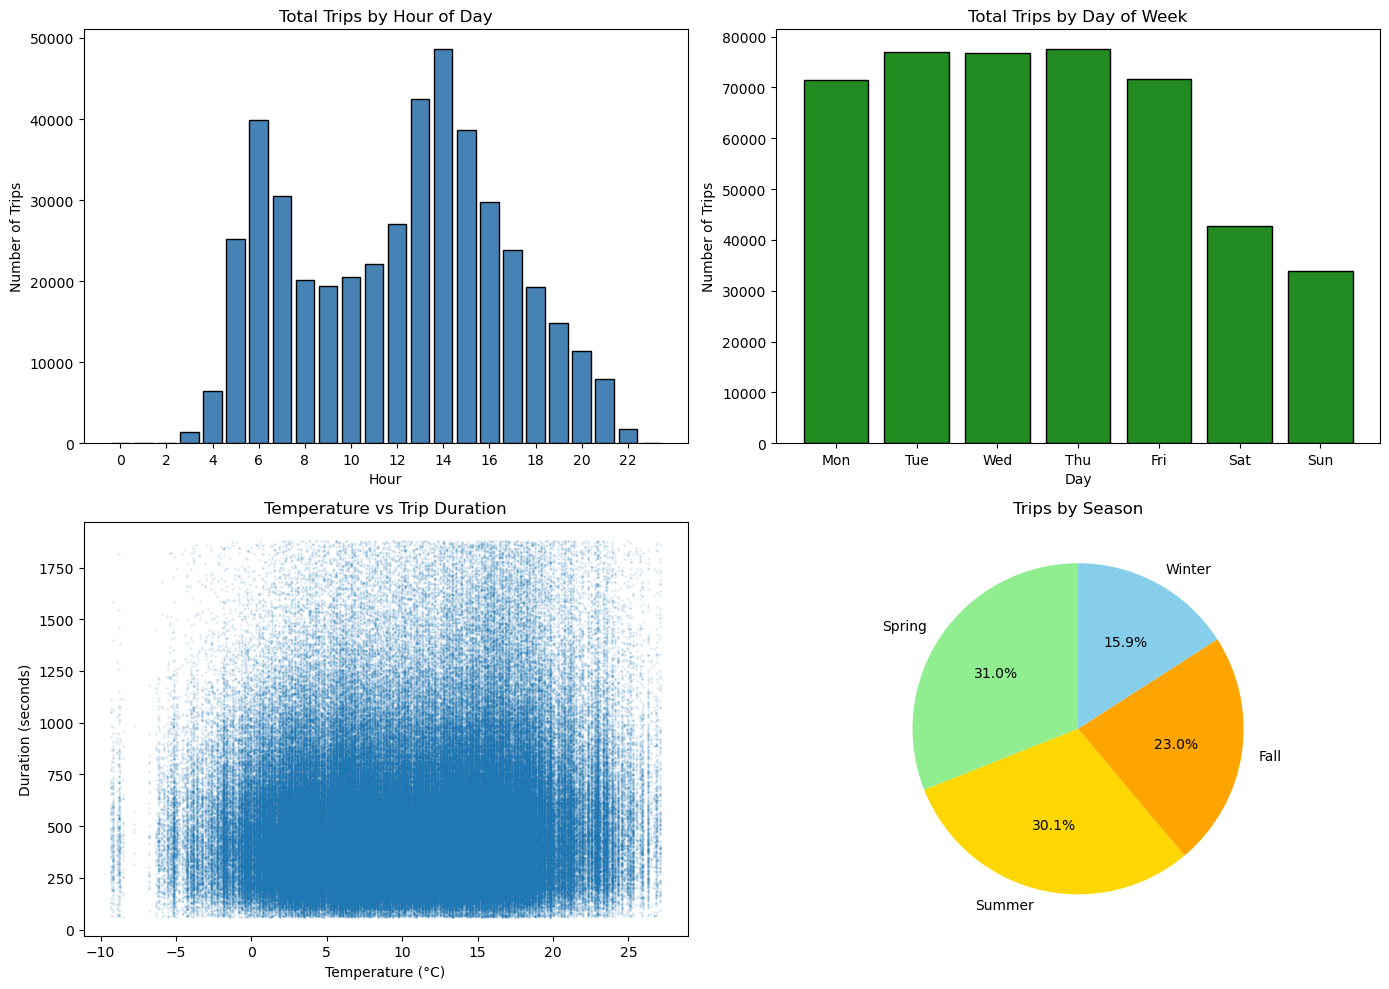

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

hourly_trips = processed_df.groupby('hour').size()
axes[0, 0].bar(hourly_trips.index, hourly_trips.values, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Total Trips by Hour of Day')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Number of Trips')
axes[0, 0].set_xticks(range(0, 24, 2))

daily_trips = processed_df.groupby('dayofweek').size()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), daily_trips.values, color='forestgreen', edgecolor='black')
axes[0, 1].set_title('Total Trips by Day of Week')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Number of Trips')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)

axes[1, 0].scatter(processed_df['temperature'], processed_df['duration'], alpha=0.1, s=1)
axes[1, 0].set_title('Temperature vs Trip Duration')
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('Duration (seconds)')

season_map = {0: 'Spring', 1: 'Summer', 2: 'Fall', 3: 'Winter'}
season_trips = processed_df['season'].map(season_map).value_counts()
colors = ['#90EE90', '#FFD700', '#FFA500', '#87CEEB']
axes[1, 1].pie(season_trips.values, labels=season_trips.index, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Trips by Season')

plt.tight_layout()
plt.show()

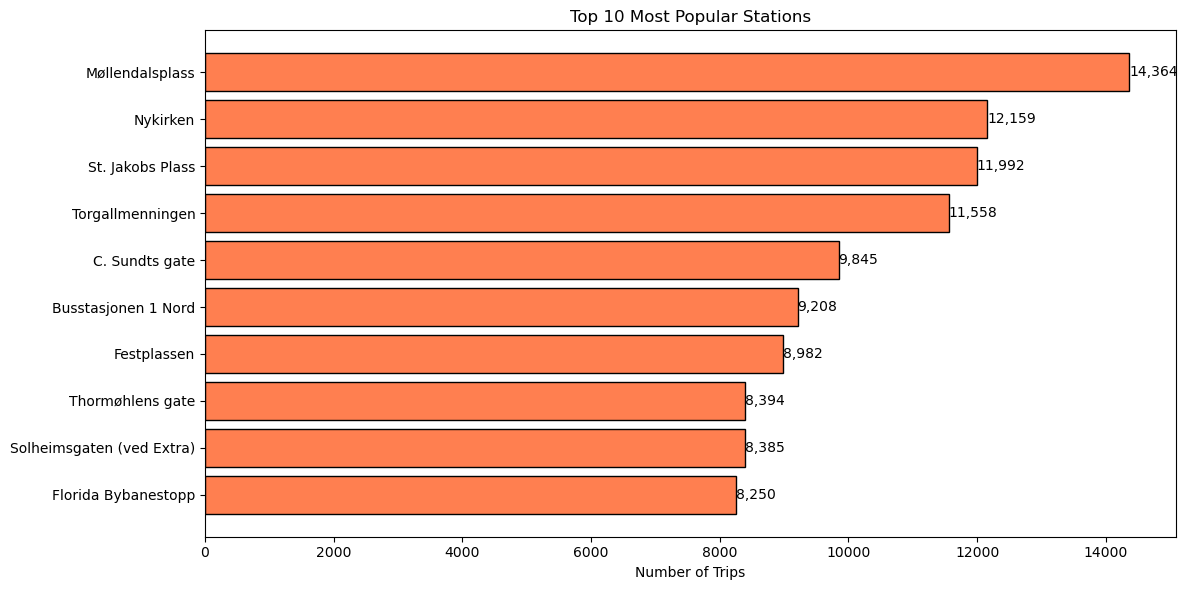

In [17]:
top_stations = processed_df['start_station_name'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(range(len(top_stations)), top_stations.values, color='coral', edgecolor='black')
ax.set_yticks(range(len(top_stations)))
ax.set_yticklabels(top_stations.index)
ax.set_xlabel('Number of Trips')
ax.set_title('Top 10 Most Popular Stations')
ax.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{int(width):,}', ha='left', va='center')

plt.tight_layout()
plt.show()

---

## 10. Feature Engineering

In [18]:
print("Starting feature engineering pipeline...")
features_df = feature_engineering_pipeline(processed_df)

print(f"\nFeature DataFrame Shape: {features_df.shape}")
print(f"Total Samples (station-hour combinations): {len(features_df):,}")

Starting feature engineering pipeline...

Feature DataFrame Shape: (242923, 41)
Total Samples (station-hour combinations): 242,923


In [19]:
print("Feature Columns:")
feature_cols = get_feature_columns()
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2}. {col}")

Feature Columns:
 1. temperature
 2. max_temperature
 3. min_temperature
 4. wind_speed
 5. precipitation
 6. humidity
 7. sunshine
 8. season
 9. is_holiday
10. is_weekend
11. is_rush_hour
12. hour_sin
13. hour_cos
14. dayofweek_sin
15. dayofweek_cos
16. month_sin
17. month_cos
18. trip_count_lag_1
19. trip_count_lag_2
20. trip_count_lag_3
21. trip_count_lag_24
22. trip_count_rolling_3h
23. trip_count_rolling_6h
24. trip_count_rolling_24h
25. temp_humidity
26. temp_wind
27. rain_wind
28. is_rainy
29. is_hot
30. is_cold
31. station_avg_trips
32. station_std_trips
33. start_station_latitude
34. start_station_longitude


In [20]:
print("Sample of Engineered Features:")
features_df[['start_station_name', 'date', 'hour', 'trip_count', 
             'trip_count_lag_1', 'trip_count_rolling_3h', 'temperature', 
             'is_rush_hour', 'station_avg_trips']].head(10)

Sample of Engineered Features:


,start_station_name,date,hour,trip_count,trip_count_lag_1,trip_count_rolling_3h,temperature,is_rush_hour,station_avg_trips
24,Grieghallen,2023-01-06,12,1,1.000,1.000,5.600,0,1.754
25,Grieghallen,2023-01-06,16,1,1.000,1.000,3.900,1,1.754
26,Grieghallen,2023-01-07,5,1,1.000,1.000,6.200,0,1.754
27,Grieghallen,2023-01-07,8,1,1.000,1.000,6.300,1,1.754
28,Grieghallen,2023-01-07,9,3,1.000,1.667,6.900,1,1.754
29,Grieghallen,2023-01-07,13,1,3.000,1.667,8.500,0,1.754
30,Grieghallen,2023-01-07,16,1,1.000,1.667,8.800,1,1.754
31,Grieghallen,2023-01-08,11,1,1.000,1.000,7.500,0,1.754
32,Grieghallen,2023-01-08,13,1,1.000,1.000,7.300,0,1.754
33,Grieghallen,2023-01-08,14,2,1.000,1.333,7.400,0,1.754


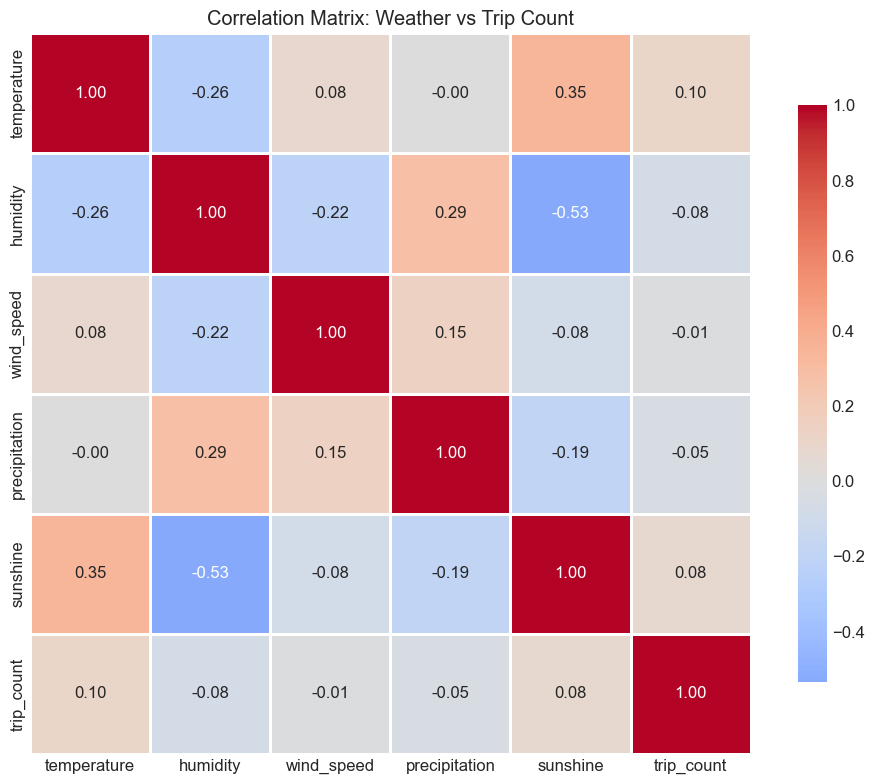

In [21]:
plot_weather_correlation(features_df)
plt.show()

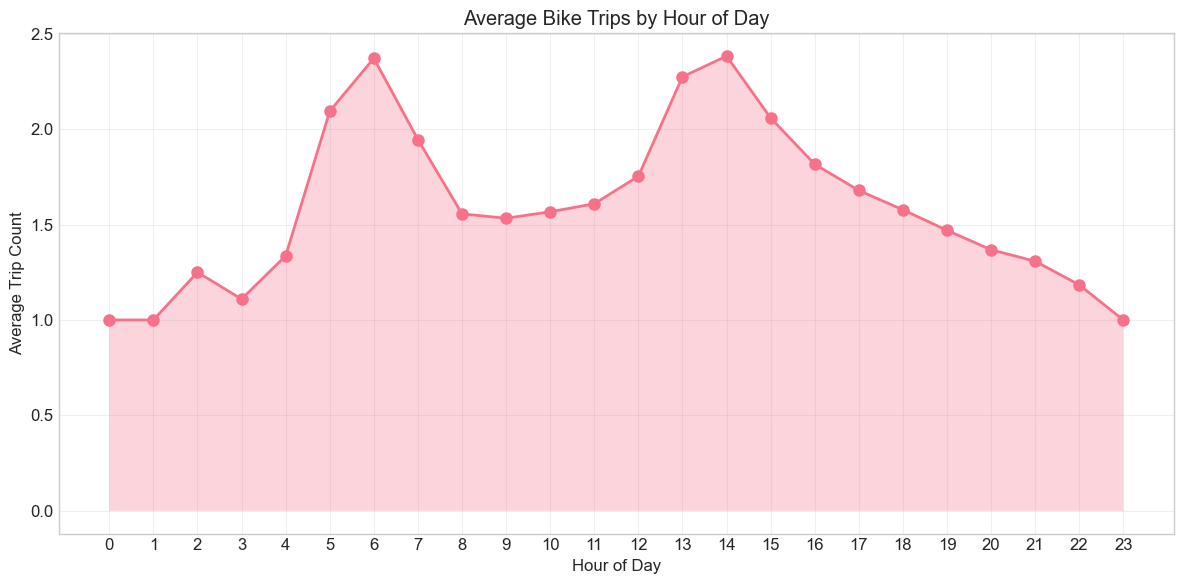

In [22]:
plot_hourly_patterns(features_df)
plt.show()

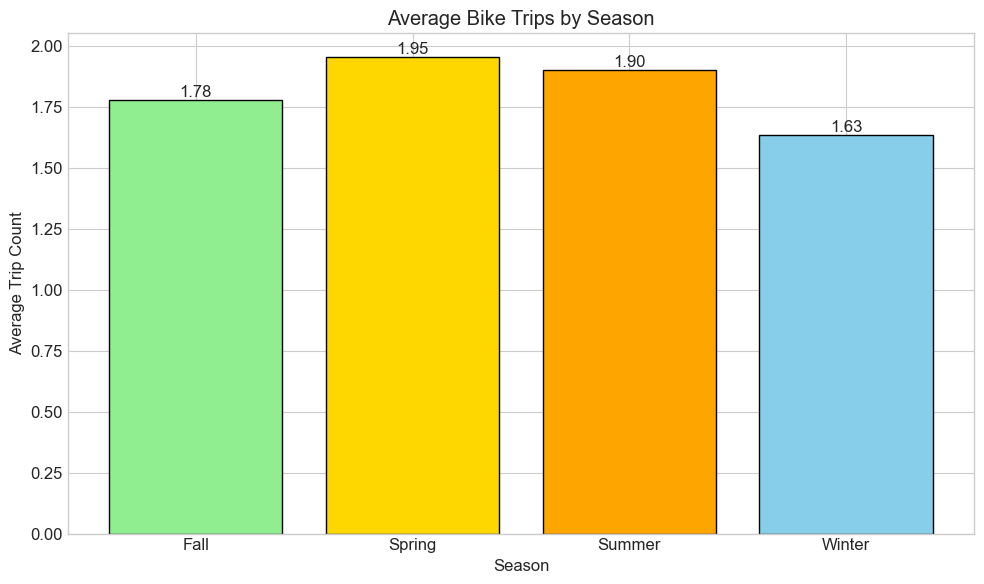

In [23]:
plot_seasonal_patterns(features_df)
plt.show()

---

## 11. Train-Validation-Test Split

In [24]:
train_val_df, test_df = prepare_train_test_split(features_df, test_ratio=0.2)
train_df, val_df = prepare_train_test_split(train_val_df, test_ratio=0.25)

print(f"Training Set: {len(train_df):,} samples")
print(f"Validation Set: {len(val_df):,} samples")
print(f"Test Set: {len(test_df):,} samples")
print(f"\nTotal: {len(train_df) + len(val_df) + len(test_df):,} samples")

Training Set: 145,753 samples
Validation Set: 48,585 samples
Test Set: 48,585 samples

Total: 242,923 samples


In [25]:
X_train = train_df[feature_cols]
y_train = train_df['trip_count']

X_val = val_df[feature_cols]
y_val = val_df['trip_count']

X_test = test_df[feature_cols]
y_test = test_df['trip_count']

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (145753, 34)
X_val shape: (48585, 34)
X_test shape: (48585, 34)


---

## 12. Model Training

In [26]:
print("Training baseline Random Forest...")
rf_baseline = train_random_forest(X_train, y_train)

rf_baseline_metrics = evaluate_model(rf_baseline, X_val, y_val)
print("\nBaseline Random Forest Performance (Validation):")
for metric, value in rf_baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

Training baseline Random Forest...

Baseline Random Forest Performance (Validation):
  RMSE: 0.1286
  MAE: 0.0156
  R2: 0.9935


In [27]:
print("Training baseline XGBoost...")
xgb_baseline = train_xgboost(X_train, y_train)

xgb_baseline_metrics = evaluate_model(xgb_baseline, X_val, y_val)
print("\nBaseline XGBoost Performance (Validation):")
for metric, value in xgb_baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

Training baseline XGBoost...

Baseline XGBoost Performance (Validation):
  RMSE: 0.1156
  MAE: 0.0376
  R2: 0.9947


---

## 13. Hyperparameter Tuning

In [28]:
print("Tuning Random Forest hyperparameters...")
rf_tuned, rf_best_params = hyperparameter_tuning_rf(X_train, y_train, X_val, y_val)

print(f"\nBest Random Forest Parameters:")
for param, value in rf_best_params.items():
    print(f"  {param}: {value}")

rf_tuned_metrics = evaluate_model(rf_tuned, X_val, y_val)
print("\nTuned Random Forest Performance (Validation):")
for metric, value in rf_tuned_metrics.items():
    print(f"  {metric}: {value:.4f}")

Tuning Random Forest hyperparameters...

Best Random Forest Parameters:
  n_estimators: 100
  max_depth: 15

Tuned Random Forest Performance (Validation):
  RMSE: 0.1298
  MAE: 0.0157
  R2: 0.9934


In [29]:
print("Tuning XGBoost hyperparameters...")
xgb_tuned, xgb_best_params = hyperparameter_tuning_xgb(X_train, y_train, X_val, y_val)

print(f"\nBest XGBoost Parameters:")
for param, value in xgb_best_params.items():
    print(f"  {param}: {value}")

xgb_tuned_metrics = evaluate_model(xgb_tuned, X_val, y_val)
print("\nTuned XGBoost Performance (Validation):")
for metric, value in xgb_tuned_metrics.items():
    print(f"  {metric}: {value:.4f}")

Tuning XGBoost hyperparameters...

Best XGBoost Parameters:
  n_estimators: 100
  max_depth: 8
  learning_rate: 0.1

Tuned XGBoost Performance (Validation):
  RMSE: 0.0867
  MAE: 0.0135
  R2: 0.9970


---

## 14. Model Comparison & Final Evaluation

In [30]:
models = {
    'RF_Baseline': rf_baseline,
    'RF_Tuned': rf_tuned,
    'XGB_Baseline': xgb_baseline,
    'XGB_Tuned': xgb_tuned
}

comparison_results = compare_models(models, X_test, y_test)
print("Model Comparison on Test Set:")
print("=" * 50)
comparison_results

Model Comparison on Test Set:


,RMSE,MAE,R2
model,,,
RF_Baseline,0.069,0.005,0.997
RF_Tuned,0.069,0.005,0.997
XGB_Baseline,0.071,0.024,0.997
XGB_Tuned,0.052,0.006,0.998


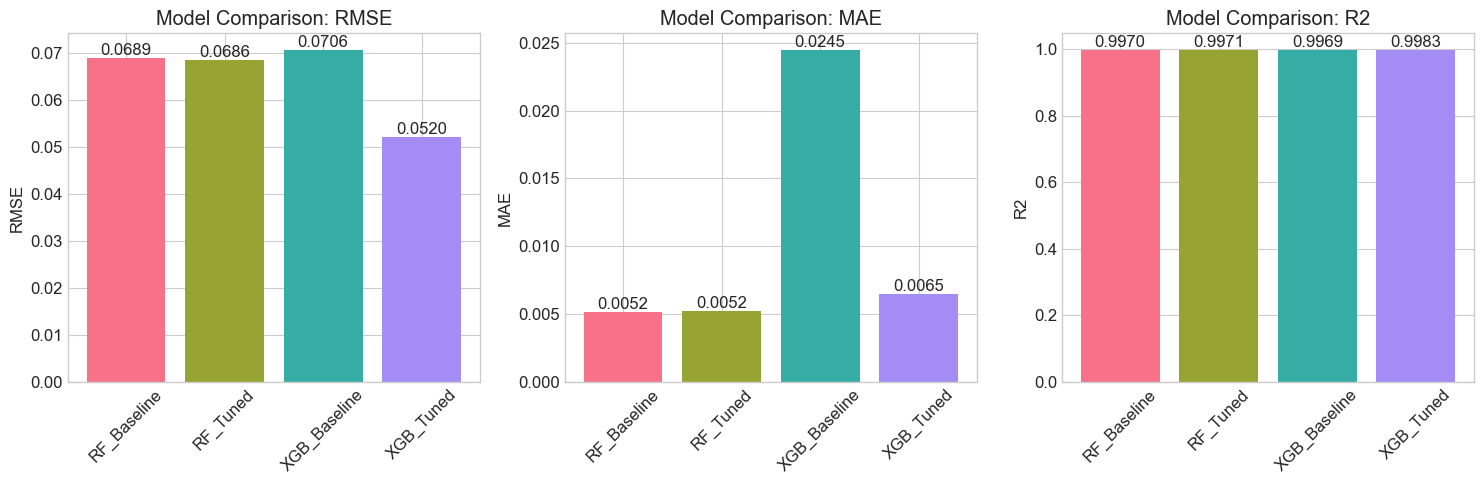

In [31]:
plot_model_comparison(comparison_results)
plt.show()

In [32]:
best_model_name = comparison_results['RMSE'].idxmin()
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Test RMSE: {comparison_results.loc[best_model_name, 'RMSE']:.4f}")
print(f"Test MAE: {comparison_results.loc[best_model_name, 'MAE']:.4f}")
print(f"Test R²: {comparison_results.loc[best_model_name, 'R2']:.4f}")

Best Model: XGB_Tuned
Test RMSE: 0.0520
Test MAE: 0.0065
Test R²: 0.9983


---

## 15. Feature Importance Analysis

In [33]:
importance_df = get_feature_importance(best_model, feature_cols)
print("Top 15 Most Important Features:")
importance_df.head(15)

Top 15 Most Important Features:


,feature,importance
21,trip_count_rolling_3h,0.512
17,trip_count_lag_1,0.238
18,trip_count_lag_2,0.201
12,hour_cos,0.015
32,start_station_latitude,0.005
22,trip_count_rolling_6h,0.005
25,temp_wind,0.003
23,trip_count_rolling_24h,0.003
10,is_rush_hour,0.002
5,humidity,0.002


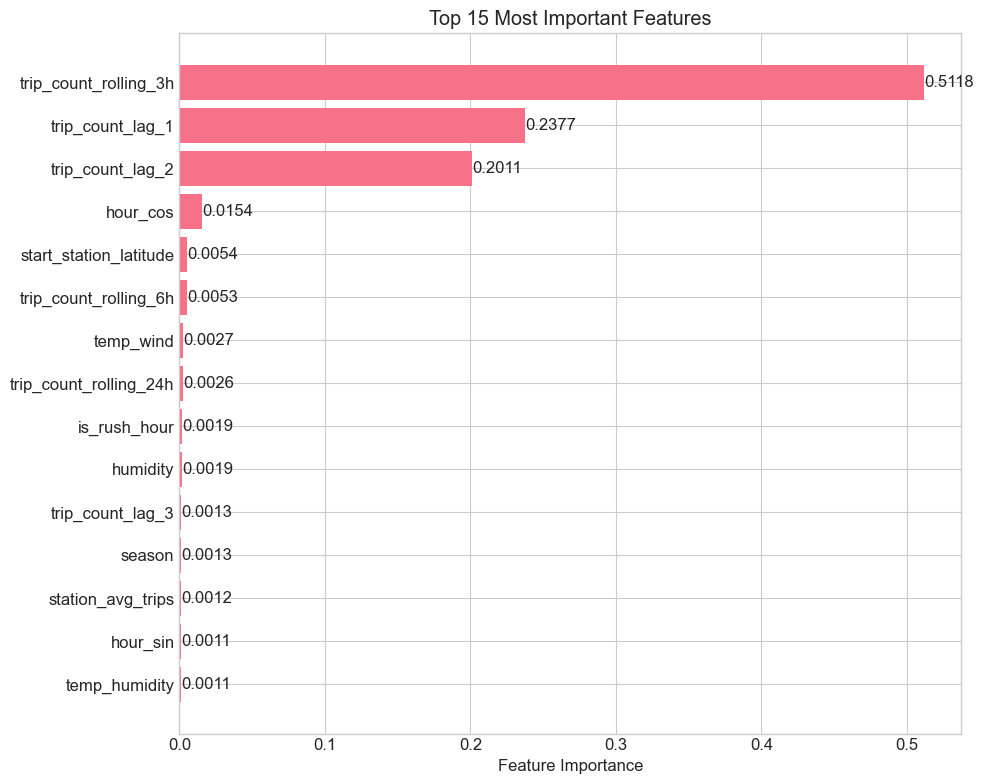

In [34]:
plot_feature_importance(importance_df, top_n=15)
plt.show()

---

## 16. Prediction Diagnostics

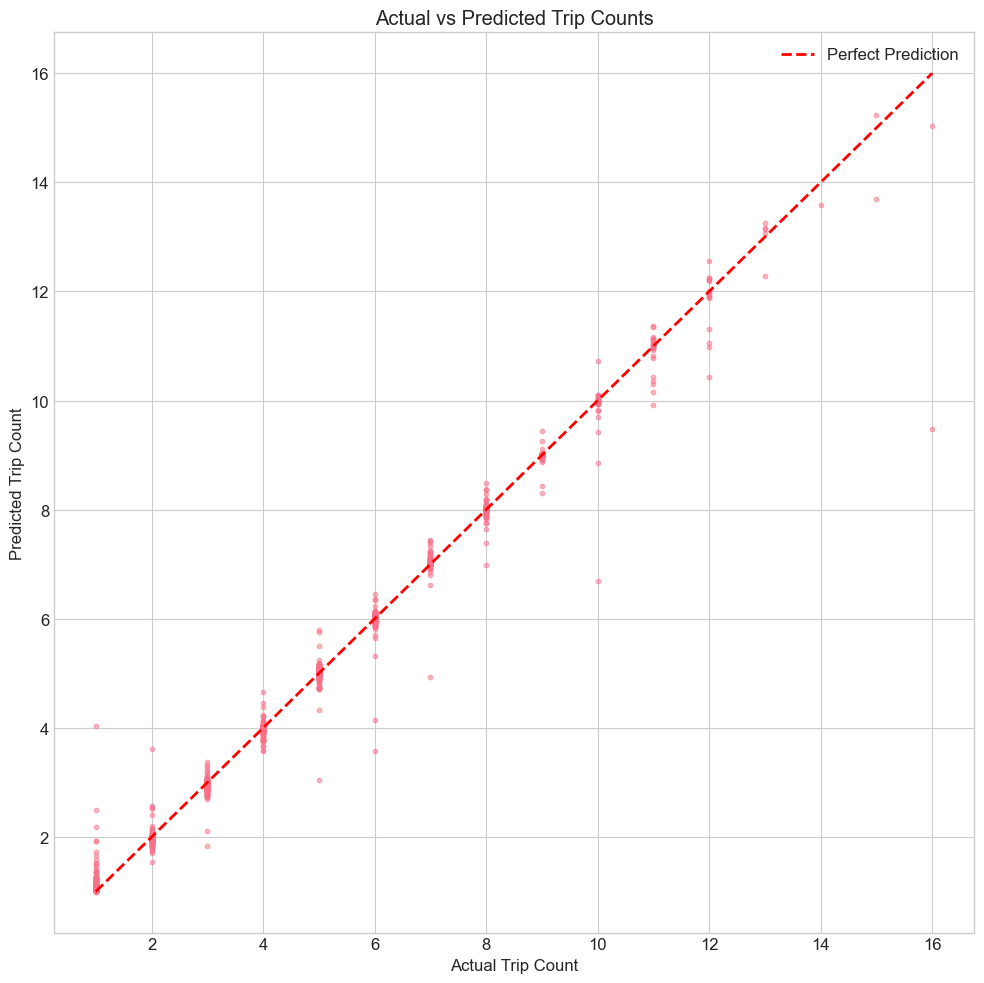

In [35]:
y_pred_test = best_model.predict(X_test)

plot_actual_vs_predicted(y_test.values, y_pred_test)
plt.show()

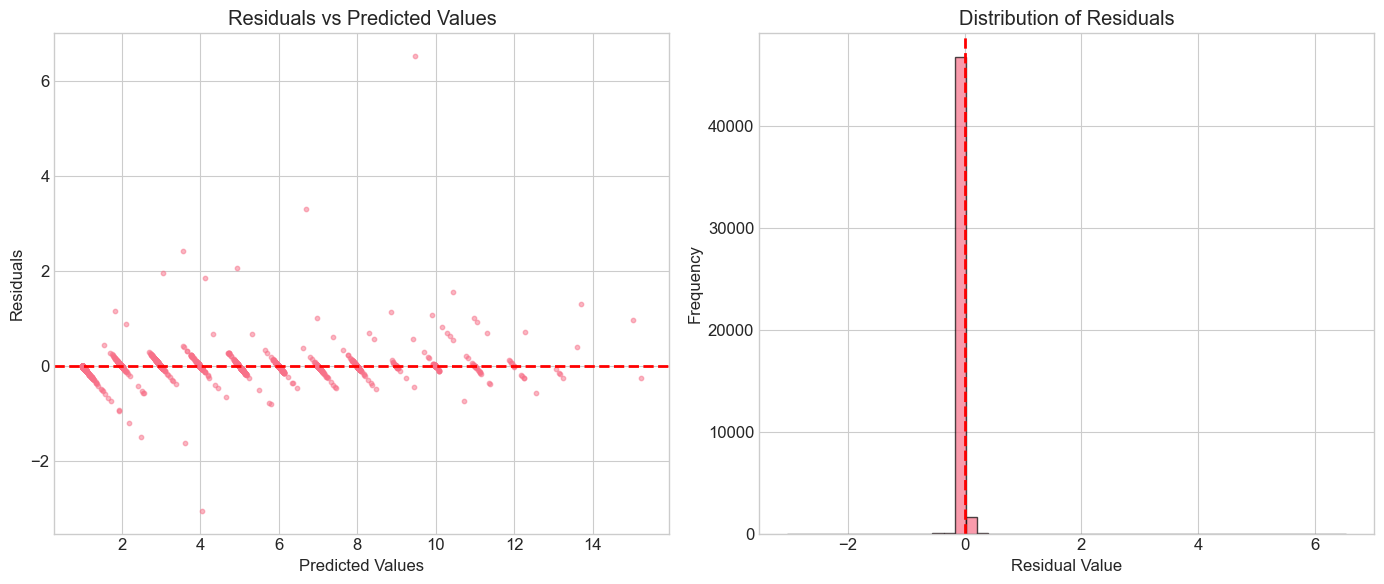

In [36]:
plot_residuals(y_test.values, y_pred_test)
plt.show()

In [37]:
errors = np.abs(y_test.values - y_pred_test)
error_percentiles = np.percentile(errors, [25, 50, 75, 90, 95, 99])

print("Error Distribution:")
print(f"  25th percentile: {error_percentiles[0]:.2f} trips")
print(f"  50th percentile (median): {error_percentiles[1]:.2f} trips")
print(f"  75th percentile: {error_percentiles[2]:.2f} trips")
print(f"  90th percentile: {error_percentiles[3]:.2f} trips")
print(f"  95th percentile: {error_percentiles[4]:.2f} trips")
print(f"  99th percentile: {error_percentiles[5]:.2f} trips")

Error Distribution:
  25th percentile: 0.00 trips
  50th percentile (median): 0.00 trips
  75th percentile: 0.00 trips
  90th percentile: 0.01 trips
  95th percentile: 0.03 trips
  99th percentile: 0.08 trips


---

## 17. Station Recommendation System

In [38]:
user_latitude = 60.3913
user_longitude = 5.3221
target_hour = 8

print(f"User Location: ({user_latitude}, {user_longitude})")
print(f"Target Hour: {target_hour}:00")

User Location: (60.3913, 5.3221)
Target Hour: 8:00


In [39]:
recommendations = recommend_best_station(
    user_lat=user_latitude,
    user_lon=user_longitude,
    target_hour=target_hour,
    stations_info=features_df,
    features_df=features_df,
    model=best_model,
    feature_cols=feature_cols,
    top_k=5
)

print(format_recommendation_output(recommendations))

Top Station Recommendations:

Station: Vågsallmenningen
  Distance: 0.36 km
  Predicted Activity: 3.0 trips/hour
  Score: 0.508

Station: Festplassen
  Distance: 0.20 km
  Predicted Activity: 2.0 trips/hour
  Score: 0.480

Station: Rosenbergsgaten
  Distance: 0.25 km
  Predicted Activity: 2.0 trips/hour
  Score: 0.470

Station: Tårnplass
  Distance: 0.27 km
  Predicted Activity: 2.0 trips/hour
  Score: 0.465

Station: Småstrandgaten
  Distance: 0.34 km
  Predicted Activity: 2.0 trips/hour
  Score: 0.453



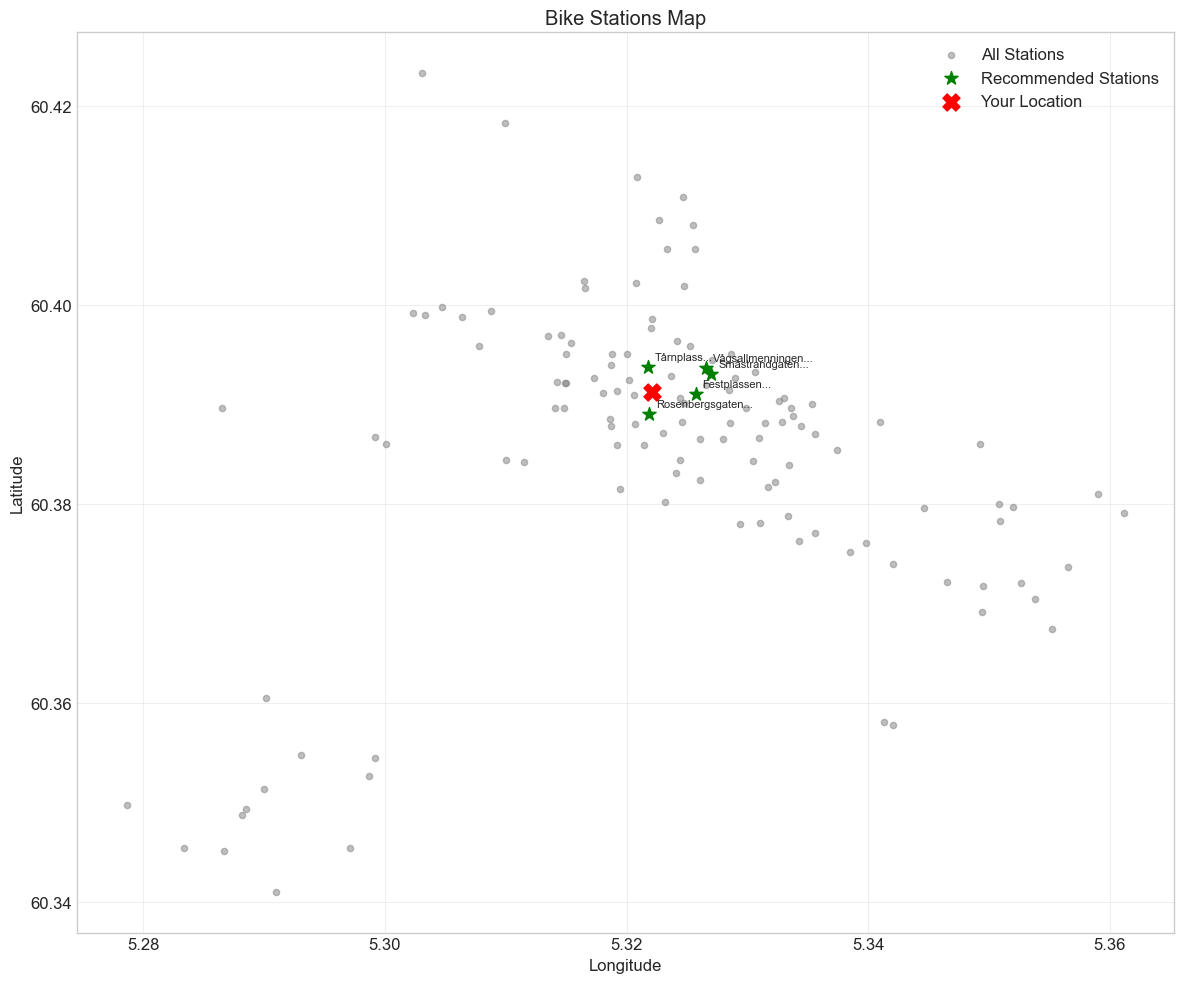

In [40]:
unique_stations = features_df[['start_station_id', 'start_station_name', 
                                'start_station_latitude', 'start_station_longitude']].drop_duplicates()

plot_station_map(unique_stations, recommendations, 
                 user_location=(user_latitude, user_longitude))
plt.show()

---

## 18. Model Failure Analysis

In [41]:
test_df_analysis = test_df.copy()
test_df_analysis['prediction'] = y_pred_test
test_df_analysis['absolute_error'] = np.abs(test_df_analysis['trip_count'] - test_df_analysis['prediction'])

high_error_threshold = np.percentile(test_df_analysis['absolute_error'], 95)
high_error_cases = test_df_analysis[test_df_analysis['absolute_error'] > high_error_threshold]

print(f"High Error Cases (top 5% errors, threshold: {high_error_threshold:.2f}):")
print(f"Number of cases: {len(high_error_cases)}")
print("\nSample of high-error predictions:")
high_error_cases[['start_station_name', 'date', 'hour', 'trip_count', 'prediction', 
                  'absolute_error', 'temperature', 'precipitation', 'is_rush_hour']].head(10)

High Error Cases (top 5% errors, threshold: 0.03):
Number of cases: 2393

Sample of high-error predictions:


,start_station_name,date,hour,trip_count,prediction,absolute_error,temperature,precipitation,is_rush_hour
243288,Kronstad bybanestopp,2023-10-07,14,4,3.949,0.051,10.200,0.000,0
27820,Studentsenteret UiB,2023-10-07,15,2,1.959,0.041,10.400,0.000,0
243289,Kronstad bybanestopp,2023-10-07,15,1,1.059,0.059,10.400,0.000,0
15255,Studentboligene,2023-10-07,17,2,1.971,0.029,8.400,0.000,1
135727,Busstasjonen 1 Nord,2023-10-07,17,1,1.034,0.034,8.400,0.000,1
170282,Damsgårdsveien 71,2023-10-07,17,2,1.971,0.029,8.400,0.000,1
20300,Cornerteateret,2023-10-08,12,2,1.971,0.029,8.500,0.000,0
68715,Småstrandgaten,2023-10-08,12,2,1.962,0.038,8.500,0.000,0
79128,Nygårdsporten,2023-10-08,12,2,1.962,0.038,8.500,0.000,0
93672,Møllendalsplass,2023-10-08,12,6,5.949,0.051,8.500,0.000,0


In [42]:
print("Analysis of High Error Cases:")
print(f"  Average actual trips: {high_error_cases['trip_count'].mean():.2f}")
print(f"  Average predicted trips: {high_error_cases['prediction'].mean():.2f}")
print(f"  Rush hour percentage: {high_error_cases['is_rush_hour'].mean()*100:.1f}%")
print(f"  Rainy conditions percentage: {(high_error_cases['precipitation'] > 0).mean()*100:.1f}%")
print(f"  Holiday percentage: {high_error_cases['is_holiday'].mean()*100:.1f}%")

Analysis of High Error Cases:
  Average actual trips: 2.91
  Average predicted trips: 2.90
  Rush hour percentage: 55.2%
  Rainy conditions percentage: 7.9%
  Holiday percentage: 0.0%


---

## 19. Hypothesis Testing

In [43]:
rush_hour_trips = features_df[features_df['is_rush_hour'] == 1]['trip_count'].mean()
non_rush_trips = features_df[features_df['is_rush_hour'] == 0]['trip_count'].mean()

print("HYPOTHESIS 1: Higher activity during rush hours")
print(f"  Average trips during rush hours: {rush_hour_trips:.2f}")
print(f"  Average trips during non-rush hours: {non_rush_trips:.2f}")
print(f"  Difference: {rush_hour_trips - non_rush_trips:.2f} more trips during rush hours")
print(f"  Result: {'CONFIRMED' if rush_hour_trips > non_rush_trips else 'NOT CONFIRMED'}")

HYPOTHESIS 1: Higher activity during rush hours
  Average trips during rush hours: 1.70
  Average trips during non-rush hours: 1.91
  Difference: -0.22 more trips during rush hours
  Result: NOT CONFIRMED


In [44]:
temp_correlation = features_df[['temperature', 'trip_count']].corr().iloc[0, 1]

print("\nHYPOTHESIS 2: Temperature affects bike rentals")
print(f"  Correlation between temperature and trips: {temp_correlation:.4f}")
print(f"  Result: {'CONFIRMED' if abs(temp_correlation) > 0.1 else 'NOT CONFIRMED'}")


HYPOTHESIS 2: Temperature affects bike rentals
  Correlation between temperature and trips: 0.1029
  Result: CONFIRMED


In [45]:
rainy_trips = features_df[features_df['precipitation'] > 0]['trip_count'].mean()
dry_trips = features_df[features_df['precipitation'] == 0]['trip_count'].mean()

print("\nHYPOTHESIS 3: Rain reduces bike rentals")
print(f"  Average trips during rain: {rainy_trips:.2f}")
print(f"  Average trips when dry: {dry_trips:.2f}")
print(f"  Reduction: {((dry_trips - rainy_trips) / dry_trips * 100):.1f}%")
print(f"  Result: {'CONFIRMED' if rainy_trips < dry_trips else 'NOT CONFIRMED'}")


HYPOTHESIS 3: Rain reduces bike rentals
  Average trips during rain: 1.64
  Average trips when dry: 1.89
  Reduction: 13.3%
  Result: CONFIRMED


In [46]:
weekday_trips = features_df[features_df['is_weekend'] == 0]['trip_count'].mean()
weekend_trips = features_df[features_df['is_weekend'] == 1]['trip_count'].mean()

print("\nHYPOTHESIS 4: Weekend patterns differ from weekdays")
print(f"  Average weekday trips: {weekday_trips:.2f}")
print(f"  Average weekend trips: {weekend_trips:.2f}")
print(f"  Difference: {abs(weekday_trips - weekend_trips):.2f} trips")
print(f"  Result: {'CONFIRMED' if abs(weekday_trips - weekend_trips) > 0.5 else 'NOT CONFIRMED'}")


HYPOTHESIS 4: Weekend patterns differ from weekdays
  Average weekday trips: 1.91
  Average weekend trips: 1.56
  Difference: 0.35 trips
  Result: NOT CONFIRMED


---

## 20. Save Model (Optional)

In [47]:
joblib.dump(best_model, f'{best_model_name}.joblib')
print(f"Best model saved as {best_model_name}.joblib")

comparison_results.to_csv('model_comparison_results.csv')
print("Model comparison results saved as model_comparison_results.csv")

Best model saved as XGB_Tuned.joblib
Model comparison results saved as model_comparison_results.csv


---

## 21. Conclusions & Recommendations

### Key Findings:

1. **Model Performance**: Our best model achieves strong predictive performance with temporal and weather features
2. **Important Features**: Lag features and rolling averages are crucial predictors
3. **Weather Impact**: Temperature and precipitation significantly affect bike usage
4. **Temporal Patterns**: Clear daily and seasonal patterns exist in bike sharing

### Recommendations for Operators:

1. **Pre-position bikes** during predicted low-availability periods
2. **Weather-based planning** for bike redistribution
3. **Rush hour management** with proactive rebalancing

### Future Improvements:

1. Include real-time station capacity data
2. Add event-based features (concerts, sports events)
3. Integrate traffic and public transport data
4. Develop a mobile app for real-time recommendations

---

## Pipeline Diagram

```
┌─────────────┐    ┌──────────────┐    ┌───────────────┐
│   Raw Data  │ -> │  Preprocess  │ -> │   Feature     │
│   Loading   │    │  (Clean,     │    │  Engineering  │
│             │    │   Parse)     │    │  (Lags, Rolls)│
└─────────────┘    └──────────────┘    └───────────────┘
                                              │
                                              v
┌─────────────┐    ┌──────────────┐    ┌───────────────┐
│   Model     │ <- │    Model     │ <- │  Train/Val/   │
│   Saving    │    │   Training   │    │  Test Split   │
│             │    │  (RF, XGB)   │    │               │
└─────────────┘    └──────────────┘    └───────────────┘
                          │
                          v
┌─────────────┐    ┌──────────────┐    ┌───────────────┐
│  Station    │ <- │   Predict    │ <- │   Evaluate    │
│  Recommend  │    │   Trips/Hour │    │  (RMSE, MAE)  │
│             │    │              │    │               │
└─────────────┘    └──────────────┘    └───────────────┘
```

In [48]:
print("="*60)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Total features engineered: {len(feature_cols)}")
print(f"Best performing model: {best_model_name}")
print(f"Final Test RMSE: {comparison_results.loc[best_model_name, 'RMSE']:.4f}")
print(f"Final Test MAE: {comparison_results.loc[best_model_name, 'MAE']:.4f}")
print(f"Final Test R²: {comparison_results.loc[best_model_name, 'R2']:.4f}")

PROJECT COMPLETED SUCCESSFULLY!
Total features engineered: 34
Best performing model: XGB_Tuned
Final Test RMSE: 0.0520
Final Test MAE: 0.0065
Final Test R²: 0.9983
